# Transfer learning and fine tuning for image classification

## Transfer learning

### Importing the libraries

In [ ]:
!pip install tensorflow-gpu==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
from keras.models import save_model

### Loading the images

In [ ]:
path = 'homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('homer_bart_2/training_set',
                                                       target_size=(256, 256),
                                                       batch_size=8,
                                                       class_mode='categorical',
                                                       shuffle=True)

Found 215 images belonging to 2 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('homer_bart_2/test_set',
                                                       target_size=(256, 256),
                                                       batch_size=1,
                                                       class_mode='categorical',
                                                       shuffle=False)

Found 54 images belonging to 2 classes.


In [ ]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

### Pre-trained network

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentation: https://keras.io/api/applications/

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', 
                                            include_top=False,
                                            input_tensor=Input(shape=(256, 256, 3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

### Custom dense layer

In [ ]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units=1025, activation='relu')(head_model) # 1025 = (the nuerons of GloablAveragePooling2D(2048) + 2) / 2
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(units=2, activation='softmax')(head_model)

### Building and training the neural network

In [ ]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model = Model(inputs=base_model.input, outputs=head_model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 8s 106ms/step - loss: 0.9923 - accuracy: 0.5628
Epoch 2/50
27/27 [==============================] - 3s 107ms/step - loss: 0.7176 - accuracy: 0.5953
Epoch 3/50
27/27 [==============================] - 3s 110ms/step - loss: 0.7114 - accuracy: 0.5767
Epoch 4/50
27/27 [==============================] - 3s 108ms/step - loss: 0.6386 - accuracy: 0.6326
Epoch 5/50
27/27 [==============================] - 3s 109ms/step - loss: 0.6789 - accuracy: 0.6558
Epoch 6/50
27/27 [==============================] - 3s 105ms/step - loss: 0.6399 - accuracy: 0.6326
Epoch 7/50
27/27 [==============================] - 3s 113ms/step - loss: 0.5815 - accuracy: 0.7163
Epoch 8/50
27/27 [==============================] - 3s 106ms/step - loss: 0.6053 - accuracy: 0.7070
Epoch 9/50
27/27 [==============================] - 3s 105ms/step - loss: 0.6330 - accuracy: 0.6512
Epoch 10/50
27/27 [==============================] - 3s 105ms/step - loss: 0.5598 - accuracy: 0.7209

### Evaluating the neural network

In [ ]:
predictions = model.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)
predictions

54/54 [==============================] - 2s 12ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
accuracy_score(test_dataset.classes, predictions)

0.8148148148148148

<Axes: >

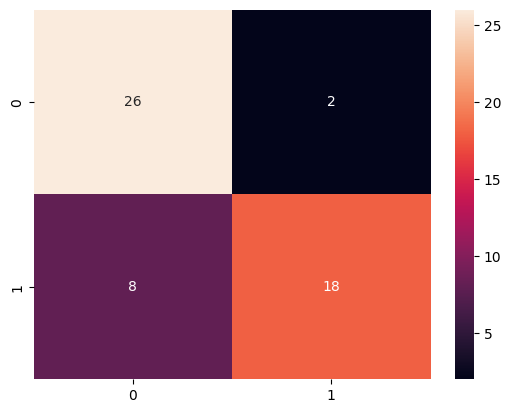

In [ ]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        28
           1       0.90      0.69      0.78        26

    accuracy                           0.81        54
   macro avg       0.83      0.81      0.81        54
weighted avg       0.83      0.81      0.81        54



## Fine tuning

### Implementing

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.layers)

175

In [ ]:
# the layer of base model can be trained from 140 to 175
fine_tuning_at = 140

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False  

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 6s 99ms/step - loss: 2.6267 - accuracy: 0.5302
Epoch 2/50
27/27 [==============================] - 3s 103ms/step - loss: 0.7420 - accuracy: 0.5488
Epoch 3/50
27/27 [==============================] - 3s 105ms/step - loss: 0.6739 - accuracy: 0.5674
Epoch 4/50
27/27 [==============================] - 3s 105ms/step - loss: 0.6323 - accuracy: 0.5860
Epoch 5/50
27/27 [==============================] - 3s 103ms/step - loss: 0.6741 - accuracy: 0.5953
Epoch 6/50
27/27 [==============================] - 3s 103ms/step - loss: 0.6316 - accuracy: 0.6140
Epoch 7/50
27/27 [==============================] - 3s 102ms/step - loss: 0.5547 - accuracy: 0.6930
Epoch 8/50
27/27 [==============================] - 3s 104ms/step - loss: 0.5407 - accuracy: 0.7349
Epoch 9/50
27/27 [==============================] - 3s 102ms/step - loss: 0.5783 - accuracy: 0.6977
Epoch 10/50
27/27 [==============================] - 3s 103ms/step - loss: 0.4862 - accuracy: 0.7488


### Evaluate 

In [ ]:
predictions = model.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)
predictions

54/54 [==============================] - 1s 11ms/step


array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
accuracy_score(test_dataset.classes, predictions)

0.7592592592592593

<Axes: >

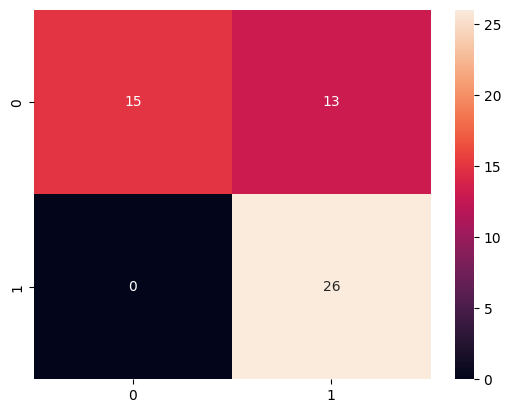

In [ ]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70        28
           1       0.67      1.00      0.80        26

    accuracy                           0.76        54
   macro avg       0.83      0.77      0.75        54
weighted avg       0.84      0.76      0.75        54



## Saving and loading the model

In [ ]:
model_json = model.to_json()
if os.path.exists('model.json'):
  os.remove('model.json')
with open('model.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
if os.path.exists('weights.hdf5'):
  os.remove('weights.hdf5')
network2_saved = save_model(model, 'weights.hdf5')

In [ ]:
with open('model.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer

In [ ]:
model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights.hdf5')
model_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Classifying one single image

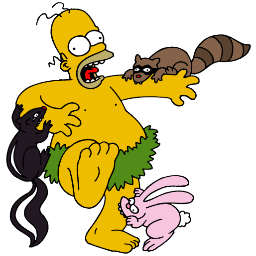

In [ ]:
image = cv2.imread('/content/homer_bart_2/test_set/homer/homer15.bmp')
image = cv2.resize(image, (256, 256))
cv2_imshow(image)

In [ ]:
image = image / 255
image = image.reshape(-1, 256, 256, 3)
image.shape

(1, 256, 256, 3)

In [ ]:
result = model_loaded(image)
result = np.argmax(result)
result

1

In [ ]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Homer
